# Recap from Analysis

**`Pclass`**
* `Pclass` highly contributes to survival, with more 1st class passengers surviving over 3rd class passengers

**`Sex`**:
* `Sex` highly contributes to survival, with more female passengers surviving over male passengers, even when qualified with `Pclass`

**`Embarked`**
* Passengers with an `Embarked` value of C tend to survive more but that may be because there is just a larger number of 1st class passengers who embarked from there. 
* When grouped with `Embarked`, `Sex` and `Pclass` correlations to survival hold
* More 1st class passengers embarked from S than C, and more 1st class passengers embarked from C than Q. In general, more passengers embarked from S than C, and C than Q. Queenstown is made up mostly of 3rd class passengers, and Cherbourg has more 1st class passengers than 3rd or 2nd class passengers.
* No definite relationship between `Embarked` and `Survival` except what can be explained by `Pclass`
* **`Embarked` may be a removable feature, but can still be used for feature engineering**

**`Ticket`**
* `Ticket` contains some mistakes in spelling (STON vs SOTON, PARIS vs Paris)
* Passengers who rode together have the same ticket number, allowing us to group into travel groups/families
* Passengers with the same ticket value also have the same `Fare` (usually), similar `cabins`, and the same `Embarked` value

**`Name`**
* `Name` consists of several titles. Each passenger has some kind of title. 
* The title can be used to impute age values.

**`Fare`**
* `Fare` is correlated slightly with `Embarked`, but only because there is a higher percentage of 1st class passengers in `Embarked == C`. In `Embarked == S`, the mean fare is slightly lower than `Embarked == C`.
* There is an outlier `Fare`, a passenger embarking from Cherbourg, Thomas Cardeza.

**`Cabin`**
* `Cabin == B, Cabin == C` has the highest survival rates. These are also the most expensive cabins, and contain the majority of 1st class passengers.
* `Cabin` should consist of only the deck values, not the number.
* There are 687 null values, so we might have to remove this column so we don't introduce too much noise.

**`Age`**
* `Age` is missing 177 values
* `Age` should be imputed since there is a spike in survival in the lower age range.
* We might be able to consider using feature bands instead of definite values to reduce granularity.

**`Sibsp` and `Parch`**
* There is no significant relationship between `Parch` and `Survived`, and `Sibsp` and `Survived`, but there is a spike in survival when `Sibsp` is greater than 2. A `Sibsp` greater than 2 means that you are in the younger range, since you can only have 1 spouse.
* For `Parch`, the relationship is less clear

---
Sections to Consider:
* Cleaning
* Transformation
* Imputing
* Feature Engineering
* Check
* Train
* Test

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.drop('PassengerId', axis=1, inplace=True)

# Cleaning

This section will be for removing rows/columns that have missing data and determining whether all data is sensible (e.g. no outliers, or inconsistent data). 

**What do we know?**
* `Name` all has titles, which is our main concern. 
* `Sex` only has 2 possible values: Male or Female
* `Fare` has a few values that are 0: these can be grouped into `Fare` feature bands.
* `Embarked` has 2 missing rows
* `Cabin` has many missing rows: might remove, but we know that cabin decks B and C have the highest chance of survival. This might also be because they are predominantly first class though, so trying to impute misisng values may still just produce unnecessary noise.
* `Parch` and `SibSp` both are reasonable with low values.
* `Pclass` has 3 unique values: 1, 2, 3
* `Ticket` is reasonable
* `Age` should be imputed. It's missing just under 200 rows, but children definitely have a higher chance of survival.

## `Embarked` Row Removal

In [3]:
train.dropna(axis=0, subset=['Embarked'], inplace=True)
train = train.reset_index(drop=True)
train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
884,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
885,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
886,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
887,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Name      889 non-null    object 
 3   Sex       889 non-null    object 
 4   Age       712 non-null    float64
 5   SibSp     889 non-null    int64  
 6   Parch     889 non-null    int64  
 7   Ticket    889 non-null    object 
 8   Fare      889 non-null    float64
 9   Cabin     202 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.5+ KB


Now there are missing values only in `Age` and `Cabin`.

## `Cabin` Column Removal

`Cabin` has many missing values, and imputing or filling in values may just introduce noise. Remove the column.

In [5]:
train.drop('Cabin', axis=1, inplace=True)
train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...
884,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
885,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
886,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,S
887,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Name      889 non-null    object 
 3   Sex       889 non-null    object 
 4   Age       712 non-null    float64
 5   SibSp     889 non-null    int64  
 6   Parch     889 non-null    int64  
 7   Ticket    889 non-null    object 
 8   Fare      889 non-null    float64
 9   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(4)
memory usage: 69.6+ KB


# Transformation/Encoding

## `Name` to `Title`

We should use one-hot-encoding and assign `Title` columns

In [7]:
title_encoded_df = train.copy()
titles_series = title_encoded_df['Name'].str.extract(r'(\w*)\..*')
one_hot_encoded_titles = pd.get_dummies(titles_series, prefix='Title', prefix_sep='')
title_encoded_df.drop('Name', axis=1, inplace=True)
display(train)
title_encoded_df = title_encoded_df.assign(**one_hot_encoded_titles.to_dict('list'))
title_encoded_df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...
884,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
885,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
886,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,S
887,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C


,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,TitleCapt,...,TitleMajor,TitleMaster,TitleMiss,TitleMlle,TitleMme,TitleMr,TitleMrs,TitleMs,TitleRev,TitleSir
0,0,3,male,22.0,1,0,A/5 21171,7.2500,S,0,...,0,0,0,0,0,1,0,0,0,0
1,1,1,female,38.0,1,0,PC 17599,71.2833,C,0,...,0,0,0,0,0,0,1,0,0,0
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,...,0,0,1,0,0,0,0,0,0,0
3,1,1,female,35.0,1,0,113803,53.1000,S,0,...,0,0,0,0,0,0,1,0,0,0
4,0,3,male,35.0,0,0,373450,8.0500,S,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,0,2,male,27.0,0,0,211536,13.0000,S,0,...,0,0,0,0,0,0,0,0,1,0
885,1,1,female,19.0,0,0,112053,30.0000,S,0,...,0,0,1,0,0,0,0,0,0,0
886,0,3,female,NaN,1,2,W./C. 6607,23.4500,S,0,...,0,0,1,0,0,0,0,0,0,0
887,1,1,male,26.0,0,0,111369,30.0000,C,0,...,0,0,0,0,0,1,0,0,0,0


In [8]:
train = title_encoded_df

## `Sex` to `IsMale`

In [9]:
sex_encoded_df = train.copy()
sex_encoded_df['Sex'] = sex_encoded_df['Sex'].astype('category').cat.codes
sex_encoded_df = sex_encoded_df.rename(columns={'Sex': 'IsMale'})

In [10]:
train = sex_encoded_df

## `Embarked` One Hot Encoding

In [11]:
embarked_encoded_df = train.copy()
one_hot_encoded_embarked = pd.get_dummies(embarked_encoded_df['Embarked'], prefix='Embarked', prefix_sep='')
embarked_encoded_df.drop('Embarked', axis=1, inplace=True)
embarked_encoded_df = embarked_encoded_df.assign(**one_hot_encoded_embarked.to_dict('list'))
embarked_encoded_df

,Survived,Pclass,IsMale,Age,SibSp,Parch,Ticket,Fare,TitleCapt,TitleCol,...,TitleMlle,TitleMme,TitleMr,TitleMrs,TitleMs,TitleRev,TitleSir,EmbarkedC,EmbarkedQ,EmbarkedS
0,0,3,1,22.0,1,0,A/5 21171,7.2500,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,1,0,38.0,1,0,PC 17599,71.2833,0,0,...,0,0,0,1,0,0,0,1,0,0
2,1,3,0,26.0,0,0,STON/O2. 3101282,7.9250,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,1,0,35.0,1,0,113803,53.1000,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0,3,1,35.0,0,0,373450,8.0500,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,0,2,1,27.0,0,0,211536,13.0000,0,0,...,0,0,0,0,0,1,0,0,0,1
885,1,1,0,19.0,0,0,112053,30.0000,0,0,...,0,0,0,0,0,0,0,0,0,1
886,0,3,0,NaN,1,2,W./C. 6607,23.4500,0,0,...,0,0,0,0,0,0,0,0,0,1
887,1,1,1,26.0,0,0,111369,30.0000,0,0,...,0,0,1,0,0,0,0,1,0,0


In [12]:
train = embarked_encoded_df

In [13]:
train

,Survived,Pclass,IsMale,Age,SibSp,Parch,Ticket,Fare,TitleCapt,TitleCol,...,TitleMlle,TitleMme,TitleMr,TitleMrs,TitleMs,TitleRev,TitleSir,EmbarkedC,EmbarkedQ,EmbarkedS
0,0,3,1,22.0,1,0,A/5 21171,7.2500,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,1,0,38.0,1,0,PC 17599,71.2833,0,0,...,0,0,0,1,0,0,0,1,0,0
2,1,3,0,26.0,0,0,STON/O2. 3101282,7.9250,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,1,0,35.0,1,0,113803,53.1000,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0,3,1,35.0,0,0,373450,8.0500,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,0,2,1,27.0,0,0,211536,13.0000,0,0,...,0,0,0,0,0,1,0,0,0,1
885,1,1,0,19.0,0,0,112053,30.0000,0,0,...,0,0,0,0,0,0,0,0,0,1
886,0,3,0,NaN,1,2,W./C. 6607,23.4500,0,0,...,0,0,0,0,0,0,0,0,0,1
887,1,1,1,26.0,0,0,111369,30.0000,0,0,...,0,0,1,0,0,0,0,1,0,0


# Imputing 

## Age Imputing

In [14]:
cols_to_remove = ['Ticket', 'Survived', 'EmbarkedQ', 'EmbarkedS', 'EmbarkedC']
imp_age_df = train.drop(cols_to_remove, axis=1)
imp_age_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pclass         889 non-null    int64  
 1   IsMale         889 non-null    int8   
 2   Age            712 non-null    float64
 3   SibSp          889 non-null    int64  
 4   Parch          889 non-null    int64  
 5   Fare           889 non-null    float64
 6   TitleCapt      889 non-null    int64  
 7   TitleCol       889 non-null    int64  
 8   TitleCountess  889 non-null    int64  
 9   TitleDon       889 non-null    int64  
 10  TitleDr        889 non-null    int64  
 11  TitleJonkheer  889 non-null    int64  
 12  TitleLady      889 non-null    int64  
 13  TitleMajor     889 non-null    int64  
 14  TitleMaster    889 non-null    int64  
 15  TitleMiss      889 non-null    int64  
 16  TitleMlle      889 non-null    int64  
 17  TitleMme       889 non-null    int64  
 18  TitleMr   

In [15]:
imputer = IterativeImputer(random_state=0)
numpy_data = imp_age_df.to_numpy()
imputer.fit(numpy_data)
df = pd.DataFrame(imputer.transform(numpy_data), columns=imp_age_df.columns)
df

,Pclass,IsMale,Age,SibSp,Parch,Fare,TitleCapt,TitleCol,TitleCountess,TitleDon,...,TitleMajor,TitleMaster,TitleMiss,TitleMlle,TitleMme,TitleMr,TitleMrs,TitleMs,TitleRev,TitleSir
0,3.0,1.0,22.000000,1.0,0.0,7.2500,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,38.000000,1.0,0.0,71.2833,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3.0,0.0,26.000000,0.0,0.0,7.9250,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,35.000000,1.0,0.0,53.1000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,3.0,1.0,35.000000,0.0,0.0,8.0500,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,2.0,1.0,27.000000,0.0,0.0,13.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
885,1.0,0.0,19.000000,0.0,0.0,30.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
886,3.0,0.0,15.633752,1.0,2.0,23.4500,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
887,1.0,1.0,26.000000,0.0,0.0,30.0000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


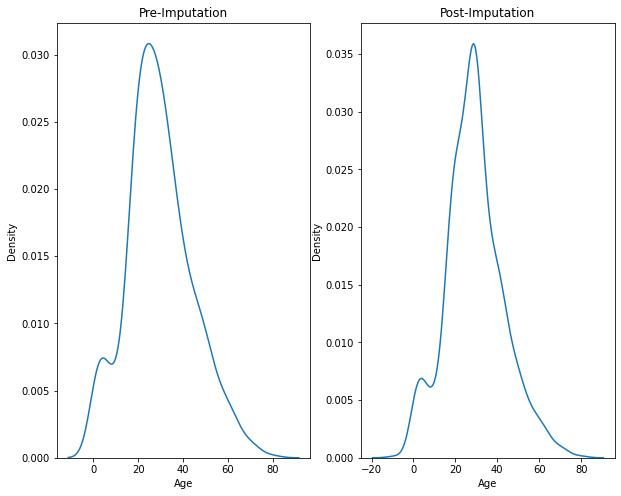

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
ax1.set_title('Pre-Imputation')
ax2.set_title('Post-Imputation')
sns.kdeplot(data=train, x='Age', ax=ax1)
sns.kdeplot(data=df, x='Age', ax=ax2)
plt.show()

In [17]:
train['Age'] = df['Age']

### 